In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
train = pd.read_csv('train.csv')
train.head()
test = pd.read_csv('test.csv')

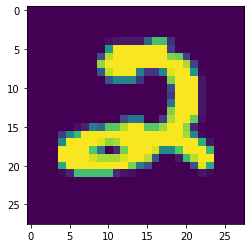

In [79]:
plt.imshow(np.array(test.iloc[[0]]).reshape(28, 28))